Chequear si la logica funciona bien (pandas, esto no funcionaba bien)

In [ ]:
import os
import pandas as pd
import ast

data_dir = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
csv_path = os.path.join(data_dir, "ptbxl_database.csv")

df = pd.read_csv(csv_path)

def es_enfermo(codes):
    codes_dict = ast.literal_eval(codes)
    return int(any(x in ["MI","STTC","HYP","CD"] for x in codes_dict.keys()))

df["enfermo"] = df["scp_codes"].apply(es_enfermo)

print(df.head(100000)["enfermo"].value_counts())


enfermo
0    21837
Name: count, dtype: int64


In [ ]:
import pandas as pd

csv_path = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv"
df = pd.read_csv(csv_path)


In [ ]:
print(df["scp_codes"].head(10).tolist()) #chequeo porque no sabía que era un enfermo y que no

["{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}", "{'NORM': 80.0, 'SBRAD': 0.0}", "{'NORM': 100.0, 'SR': 0.0}", "{'NORM': 100.0, 'SR': 0.0}", "{'NORM': 100.0, 'SR': 0.0}", "{'NORM': 100.0, 'SR': 0.0}", "{'NORM': 100.0, 'SR': 0.0}", "{'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}", "{'NORM': 100.0, 'SR': 0.0}", "{'NORM': 100.0, 'SR': 0.0}"]


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [ ]:
!unzip "/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip"

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19342_hr.dat  
  inflating: ptb-xl-a-large-p

In [ ]:
# IMPORTAR TODAS LAS LIBRERÍAS NECESARIAS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import wfdb

Conseguir las imagenes

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import ast
import shutil
import random
#ruteo y boludeces
data_dir = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
csv_path = os.path.join(data_dir, "ptbxl_database.csv")
output_dir = "/content/drive/MyDrive/ecg_images"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(csv_path)
#definimos que es un enfermo cardíaco
def es_enfermo(codes):
    codes_dict = ast.literal_eval(codes)
    keys = set(codes_dict.keys())
    # Sano si solo tiene 'NORM' y/o 'SR'
    return int(not keys.issubset({'NORM', 'SR'}))

df["enfermo"] = df["scp_codes"].apply(es_enfermo)

# 1. IDs ya tomados
pngs = [f for f in os.listdir(output_dir) if f.endswith(".png")]
ids_tomados = set(f.split("_")[0] for f in pngs)

# 2. Filtrá el DataFrame para NO tomar esos IDs
df_nuevos = df[~df["ecg_id"].astype(str).isin(ids_tomados)]
# Selecciona 1500 pacientes aleatorios del dataset total (no nos da la ram jijo)
df_sample = df_nuevos.sample(n=min(1500, len(df_nuevos)), random_state=42).reset_index(drop=True) #optimice esto y puse que solo tome los nuevos para no estar aca tan al pedo

for idx, row in df_sample.iterrows():
    record_name = row["filename_lr"]
    label = row["enfermo"]
    record_path = os.path.join(data_dir, record_name)
    if not os.path.exists(record_path + ".hea"):
        print(f"Archivo no encontrado: {record_path}.hea")
        continue
    try:
        signal, fields = wfdb.rdsamp(record_path)
        plt.figure(figsize=(10, 8))
        for i in range(12):
            plt.subplot(12, 1, i+1)
            plt.plot(signal[:, i], linewidth=0.5)
            plt.axis('off')
        plt.tight_layout()
        img_path = os.path.join(output_dir, f"{row['ecg_id']}_{label}.png")
        plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error en {record_name}: {e}")

# ---- Separación en train/test por clase ----

train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

for base_dir in [train_dir, test_dir]:
    for label in ["0", "1"]:
        os.makedirs(os.path.join(base_dir, label), exist_ok=True)

all_images = [f for f in os.listdir(output_dir) if f.endswith(".png")]
sano = [f for f in all_images if f.endswith("_0.png")]
enfermo = [f for f in all_images if f.endswith("_1.png")]

def split_and_move(images, label):
    random.shuffle(images)
    split = int(len(images) * 0.8)
    train_images = images[:split]
    test_images = images[split:]
    for f in train_images:
        shutil.move(os.path.join(output_dir, f), os.path.join(train_dir, label, f))
    for f in test_images:
        shutil.move(os.path.join(output_dir, f), os.path.join(test_dir, label, f))

split_and_move(sano, "0")
split_and_move(enfermo, "1")

print("¡Listo! Las imágenes están separadas en train/test y sano/enfermo.")


¡Listo! Las imágenes están separadas en train/test y sano/enfermo.


Cargar los datos con Keras

In [ ]:
import tensorflow as tf

train_dir = '/content/drive/MyDrive/ecg_images/train'
test_dir = '/content/drive/MyDrive/ecg_images/test'
img_size = (224, 224) #tamaño de imagen por falta de presupuesto
#logica para saber que se entrena
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=img_size,
    shuffle=True,
    seed=42
)
#lo mismo pero para testear
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=img_size,
    shuffle=False,
    seed=42
)


Found 1199 files belonging to 2 classes.
Found 301 files belonging to 2 classes.


Primera versión CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#logica de imagenes y cosas que entiendo poco
model = keras.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
#logica de entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entrenamos de chill

In [ ]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds
)


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.7242 - loss: 0.5162 - val_accuracy: 0.6875 - val_loss: 0.6129
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7270 - loss: 0.5125 - val_accuracy: 0.7336 - val_loss: 0.5106
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7586 - loss: 0.4613 - val_accuracy: 0.7072 - val_loss: 0.5843
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7831 - loss: 0.4499 - val_accuracy: 0.7445 - val_loss: 0.4984
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.8152 - loss: 0.3924 - val_accuracy: 0.6864 - val_loss: 0.7712
Epoch 6/20
 65/105 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.7990 - loss: 0.4273

KeyboardInterrupt: 

Testeamos y sufrimos cambiando valores unas cuantas veces más jijo

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"Accuracy: {acc:.2f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 861ms/step - accuracy: 0.6852 - loss: 0.7401
Accuracy: 0.78


Grafiquito para que nos quede claro todo

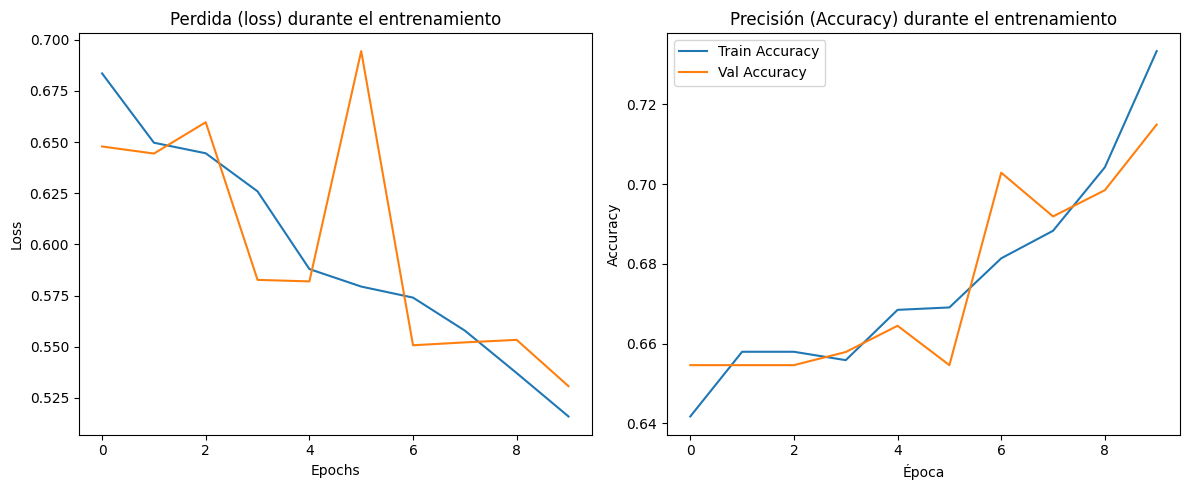

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Perdida (loss) durante el entrenamiento")

#Grafico de precisión
plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión (Accuracy) durante el entrenamiento')

plt.tight_layout()
plt.show()